## This Jupyter Notebook will be used for the Applied Data Science Capstone.

## The following code will be used for the Week 3 Assignment: Segmenting and Clustering Neighborhoods in Toronto

In [153]:
#Importing packages
import pandas as pd
import numpy as np

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [154]:
#Grabbing the data table from Wikipedia using Pandas
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

#Dropping the rows where Borough is not assigned
indexNames = df[df['Borough'] == 'Not assigned'].index
df.drop(indexNames, inplace=True)

#Concatenating the neighborhoods so that we only have one row per zip code
df = df.groupby(['Postcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()

df.shape

(103, 3)

In [155]:
#Now I will add the latitude and longitude, and delete any unecessary columns
GeoCode = pd.read_csv('Geospatial_Coordinates.csv')
df = df.merge(GeoCode, left_on=['Postcode'], right_on = ['Postal Code'])
df.drop(columns = ['Postal Code',], inplace = True)

## The Clustering Portion now begins

In [156]:
#Creating a function to get the additional information from foursquare

CLIENT_ID = 'DV5VFHJJVSUEUHTFVTDQXDCKZ23KG2Q4SCUKFOMJLKSSMX1H' 
CLIENT_SECRET = '0LHT1ZVBUHGHHIJS323EHDBDGBXUKTQMBSAVINOZOZG5LFXM' 
VERSION = '20180605'
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [157]:
Toronto = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )


Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [158]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto['Neighborhood'] 

# move neighborhood column to the first column
Toronto_onehot = Toronto_onehot.set_index('Neighborhood').reset_index()

#Now we will group the neighborhoods
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [162]:
Toronto_grouped_clustering.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.01,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.04,0.0,0.

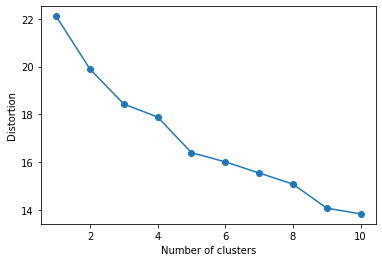

In [163]:
#Determining the optimal number of clusters

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(Toronto_grouped_clustering)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## From the above figure, we can determine that 5 is the most optimal clustering technique, since the decrease in distortion is greatest from 4 --> 5, which indicates that 3 clusters is the best choice

In [181]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
Toronto_grouped.drop(['Cluster Labels'], axis = 1, inplace = True)
Toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [182]:
#Adding the latitude and longtitude

Toronto.drop_duplicates(subset='Neighborhood', keep="last", inplace = True)
final = pd.merge(Toronto[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']], Toronto_grouped, left_on = 'Neighborhood', right_on = 'Neighborhood', how = 'inner')

In [183]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final['Neighborhood Latitude'], final['Neighborhood Longitude'], final['Neighborhood'], final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Now we can examine each cluster individually

In [211]:
clusteranalysis = final.drop(['Neighborhood Latitude', 'Neighborhood Longitude'], axis = 1)
clusteranalysis_grouped = clusteranalysis.groupby(['Cluster Labels']).sum()
clusteranalysis_grouped = clusteranalysis_grouped.reset_index()

In [221]:
#cluster 0
clusteranalysis_grouped[clusteranalysis_grouped['Cluster Labels'] == 0].sort_values(by=0, ascending=False, axis=1)

,Fast Food Restaurant,Restaurant,Sandwich Place,Cluster Labels,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Men's Store,Metro Station,Mediterranean Restaurant,Medical Center,Massage Studio,Martial Arts Dojo,Market,Monument / Landmark,Motel,Luggage Store,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Malay Restaurant,Lounge,Pharmacy,Hookah Bar,IT Services,Hotpot Restaurant,Hotel Bar,Hotel,Hostel,Hospital,Home Service,Liquor Store,Hockey Arena,Hobby Shop,History Museum,Historic Site,Health Food Store,Health & Beauty Service,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Pet Store,Playground,Pizza Place,Thai Restaurant,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Theater,Sports Bar,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Stadium,Sporting Goods Shop,Harbor / Marina,Salon / Barbershop,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,River,Roof Deck,Sake Bar,Salad Place,Scenic Lookout,Speakeasy,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Hardware Store,Hakka Restaurant,Accessories Store,Café,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Cajun / Creole Restaurant,Bistro,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,Boat or Ferry,Bike Shop,College Stadium,Auto Garage,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Belgian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,College Rec Center,Colombian Restaurant,Gym / Fitness Center,Gaming Cafe,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Filipino Restaurant,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Fish & Chips Shop,Field,Comfort Food Restaurant,Dessert Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant,Festival,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Yoga Studio
0,1.5,0.25,0.25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [222]:
#cluster 1
clusteranalysis_grouped[clusteranalysis_grouped['Cluster Labels'] == 1].sort_values(by=1, ascending=False, axis=1)

,Baseball Field,Cluster Labels,Furniture / Home Store,Food Truck,Metro Station,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Men's Store,Lounge,Mediterranean Restaurant,Medical Center,Massage Studio,Martial Arts Dojo,Market,Malay Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Opera House,Pet Store,Performing Arts Venue,Park,Other Great Outdoors,Organic Grocery,Optical Shop,Office,Movie Theater,Noodle House,Nightclub,New American Restaurant,Music Venue,Museum,Moving Target,Luggage Store,Lingerie Store,Liquor Store,Pizza Place,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Pharmacy,Playground,Hardware Store,Sushi Restaurant,Tea Room,Tanning Salon,Taiwanese Restaurant,Tailor Shop,Taco Place,Swim School,Supplement Shop,Plaza,Supermarket,Summer Camp,Strip Club,Steakhouse,Stationery Store,Stadium,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Sports Bar,Sporting Goods Shop,Speakeasy,Salon / Barbershop,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Spa,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Health & Beauty Service,Hakka Restaurant,Harbor / Marina,Cajun / Creole Restaurant,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Candy Store,Boat or Ferry,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Bookstore,Bistro,Accessories Store,Auto Garage,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Bike Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Garden,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Gaming Cafe,Garden Center,Comic Shop,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Yoga Studio
1,2.0,1,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [223]:
#cluster 2
clusteranalysis_grouped[clusteranalysis_grouped['Cluster Labels'] == 2].sort_values(by=2, ascending=False, axis=1)

,Coffee Shop,Café,Pizza Place,Cluster Labels,Bakery,Grocery Store,Sandwich Place,Park,Fast Food Restaurant,Pharmacy,Italian Restaurant,Bar,Restaurant,Gym,Clothing Store,Golf Course,Japanese Restaurant,Pub,Playground,Breakfast Spot,Garden,Chinese Restaurant,Bank,Empanada Restaurant,American Restaurant,Cafeteria,Hotel,Convenience Store,Fried Chicken Joint,Middle Eastern Restaurant,Discount Store,Burger Joint,Liquor Store,Gym / Fitness Center,Pet Store,Sushi Restaurant,Indian Restaurant,Thai Restaurant,Rental Car Location,Athletics & Sports,Hockey Arena,Vietnamese Restaurant,Caribbean Restaurant,Beer Store,Trail,Motel,Shopping Mall,Diner,Skating Rink,Bus Line,Mexican Restaurant,Supermarket,Burrito Place,Gastropub,French Restaurant,Basketball Court,Intersection,Dessert Shop,Lounge,Cosmetics Shop,Dance Studio,Korean Restaurant,Bookstore,Greek Restaurant,Brewery,Miscellaneous Shop,Furniture / Home Store,Seafood Restaurant,Latin American Restaurant,Mediterranean Restaurant,Field,Drugstore,Sporting Goods Shop,Ice Cream Shop,Steakhouse,Vegetarian / Vegan Restaurant,Bus Station,Portuguese Restaurant,Dog Run,Butcher,General Entertainment,Asian Restaurant,Gift Shop,Yoga Studio,Electronics Store,Beer Bar,Deli / Bodega,Thrift / Vintage Store,College Stadium,Construction & Landscaping,Department Store,Gas Station,Health Food Store,Tea Room,Noodle House,Farmers Market,Other Great Outdoors,Hobby Shop,Movie Theater,Bubble Tea Shop,Pool,Massage Studio,Food & Drink Shop,Theater,Nightclub,Baseball Field,Juice Bar,Light Rail Station,Cocktail Bar,Video Store,Comfort Food Restaurant,Music Venue,Smoke Shop,Ramen Restaurant,Art Gallery,Bagel Shop,Flower Shop,Home Service,Airport Lounge,Medical Center,Airport Terminal,Wings Joint,Smoothie Shop,Wine Bar,Women's Store,Sports Bar,Concert Hall,Plaza,Auto Garage,Hakka Restaurant,Spa,Arts & Crafts Store,Fish & Chips Shop,Curling Ice,Metro Station,Shopping Plaza,Soccer Field,Eastern European Restaurant,Speakeasy,Cheese Shop,Boutique,Supplement Shop,Shoe Store,Creperie,Gourmet Shop,Cuban Restaurant,BBQ Joint,Salon / Barbershop,Salad Place,Food Court,Hardware Store,Sculpture Garden,Lingerie Store,New American Restaurant,Comic Shop,Bike Shop,Candy Store,Performing Arts Venue,Fish Market,Airport,Airport Service,Airport Gate,Airport Food Court,Boat or Ferry,Harbor / Marina,Gay Bar,Toy / Game Store,Carpet Store,Accessories Store,Fraternity House,History Museum,Men's Store,Warehouse Store,Baby Store,Tailor Shop,Jazz Club,Museum,Dim Sum Restaurant,Recording Studio,Skate Park,Auto Workshop,Garden Center,Video Game Store,Hotel Bar,Frozen Yogurt Shop,Bridal Shop,Aquarium,Fountain,Basketball Stadium,Dumpling Restaurant,Stadium,Climbing Gym,Poke Place,Falafel Restaurant,Office,Cajun / Creole Restaurant,Flea Market,Gluten-free Restaurant,General Travel,Monument / Landmark,Poutine Place,Record Shop,Cupcake Shop,Jewelry Store,Bistro,Irish Pub,Donut Shop,Modern European Restaurant,Antique Shop,Event Space,Food Truck,Food,South American Restaurant,Indie Movie Theater,Building,Train Station,Scenic Lookout,College Arts Building,College Gym,Indonesian Restaurant,Costume Shop,College Auditorium,Indoor Play Area,Tennis Court,Coworking Space,Stationery Store,Fruit & Vegetable Store,Market,Taiwanese Restaurant,Ethiopian Restaurant,Moving Target,Historic Site,Chocolate Shop,Church,Hostel,Baseball Stadium,Brazilian Restaurant,Lake,Opera House,Southern / Soul Food Restaurant,Malay Restaurant,Beach,Luggage Store,Health & Beauty Service,Theme Restaurant,Afghan Restaurant,Wine Shop,Sake Bar,Strip Club,Belgian Restaurant,Hospital,Doner Restaurant,Organic Grocery,Bed & Breakfast,Hotpot Restaurant,Filipino Restaurant,Gaming Cafe,Martial Arts Dojo,Snack Place,Optical Shop,Molecular Gastronomy Restaurant,IT Services,Hookah Bar,Festival,College Rec Center,German Restaurant,Tanning Salon,Colombian Restaurant,Taco Place,Roof Deck,Swim School,Summer Camp,River
2,5.426801,2.777229,2.55218,2,1.887613,1.830192,1.789624,1.604499,1.548091,1.40352,1.37284

In [224]:
#cluster 3
clusteranalysis_grouped[clusteranalysis_grouped['Cluster Labels'] == 3].sort_values(by=3, ascending=False, axis=1)

,Cluster Labels,Bar,Metro Station,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Men's Store,Motel,Mediterranean Restaurant,Medical Center,Massage Studio,Martial Arts Dojo,Market,Malay Restaurant,Monument / Landmark,Movie Theater,Lounge,Optical Shop,Pharmacy,Pet Store,Performing Arts Venue,Park,Other Great Outdoors,Organic Grocery,Opera House,Moving Target,Office,Noodle House,Nightclub,New American Restaurant,Music Venue,Museum,Luggage Store,Liquor Store,Playground,Ice Cream Shop,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Indian Restaurant,Lingerie Store,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Pizza Place,Plaza,Harbor / Marina,Thai Restaurant,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Theater,Sports Bar,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Stadium,Sporting Goods Shop,Poke Place,Sandwich Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Scenic Lookout,Speakeasy,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Hardware Store,Hakka Restaurant,Accessories Store,Cajun / Creole Restaurant,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Candy Store,Boat or Ferry,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Bookstore,Bistro,Colombian Restaurant,Auto Garage,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Bike Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,College Stadium,Comfort Food Restaurant,Gym / Fitness Center,Gaming Cafe,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Filipino Restaurant,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Fish & Chips Shop,Field,Comic Shop,Dim Sum Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Festival,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Yoga Studio
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [225]:
#cluster 4
clusteranalysis_grouped[clusteranalysis_grouped['Cluster Labels'] == 4].sort_values(by=4, ascending=False, axis=1)

,Park,Cluster Labels,Convenience Store,Playground,Coffee Shop,Food & Drink Shop,Pizza Place,River,Airport,Trail,Bus Line,Summer Camp,Swim School,Jewelry Store,Sushi Restaurant,Bank,Fast Food Restaurant,Market,Women's Store,Indonesian Restaurant,Hospital,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Hookah Bar,Moving Target,Museum,Home Service,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Hockey Arena,Hobby Shop,History Museum,Men's Store,Mediterranean Restaurant,Indoor Play Area,Hostel,Intersection,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Ice Cream Shop,Jazz Club,IT Services,Hotpot Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Performing Arts Venue,Hotel Bar,Luggage Store,Malay Restaurant,Hotel,Martial Arts Dojo,Massage Studio,Medical Center,Lounge,Poke Place,Pet Store,Tennis Court,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Spa,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Speakeasy,Southern / Soul Food Restaurant,Pharmacy,Salad Place,Plaza,Health Food Store,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salon / Barbershop,South American Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Historic Site,Hakka Restaurant,Health & Beauty Service,Candy Store,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Hardware Store,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Bookstore,Boat or Ferry,Bistro,Bike Shop,Afghan Restaurant,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Flea Market,Food,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Accessories Store,Harbor / Marina,Flower Shop,Fish Market,Construction & Landscaping,Fish & Chips Shop,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Festival,Field,Filipino Restaurant,Yoga Studio
4,5.583333,4,1.033333,0.916667,0.666667,0.5,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.2

## From this analysis, I can infer that the clusters have the following characteristics:

## Cluster 0 is based on areas with through-traffic, due to the Fast Food and other food options available
## Cluster 1 is based on a school area, due to the presence of a base-ball field
## Cluster 2 is based on around high-density areas, due to the abundance of different venues
## Cluster 3 is bsaed on a low-density area, due to the lack of different venues
## Cluster 4 is based on a family oriented area, due to the abundance of venues that are catered towards families and children